<a target="_blank" href="https://colab.research.google.com/github/ntu-dl-bootcamp/deep-learning-2025/blob/main/SESSION2/session2_part2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Datasets and Dataloaders

PyTorch has `torch.utils.data.Dataloader` and `torch.utils.data.Dataset` to allow you to use pre-loaded data as well as your own data.

`Dataset` stores the samples and their corresponding labels.

`Dataloader` wraps an _iterable_ around the `Dataset` for easy access to samples. An iterable in python is any object which can be looped over or iterated over with the help of a for loop.

PyTorch provides a number of pre-loaded datasets. You can find them here: [Image Datasets](https://pytorch.org/vision/stable/datasets.html), [Text Datasets](https://pytorch.org/text/stable/datasets.html), and [Audio Datasets](https://pytorch.org/audio/stable/datasets.html).

## Loading a Dataset

The MNIST (Modified National Institute of Standards and Technology) dataset is a collection of 70,000 images of handwritten digits (0 through 9).

Each image is:
- Size: 28x28 pixels (small, grayscale images)
- Total Images: 60,000 for training and 10,000 for testing
- Labels: Each image is labeled with the digit it represents (0 to 9)

The MNIST dataset is widely used for learning and testing basic image processing and machine learning techniques, especially in deep learning. Since the images are simple and low-resolution, the dataset allows us to build and train models quickly.

We will load the MNIST dataset from `torchvision`. Read more about this dataset [here](https://en.wikipedia.org/wiki/MNIST_database).

In [ ]:
# Import the necessary modules from torchvision
from torchvision import datasets  # for accessing popular datasets
from torchvision.transforms import ToTensor  # for converting images to PyTorch tensors

# Download and prepare the training data
training_data = datasets.MNIST(
    root="data",  # 'root' is the directory where the dataset will be stored
    train=True,  # 'train=True' specifies that we want the training set
    download=True,  # 'download=True' will download the dataset if it's not already present
    transform=ToTensor(),  # 'transform=ToTensor()' converts the images to PyTorch tensors (needed for PyTorch models)
)

# Download and prepare the test data
test_data = datasets.MNIST(
    root="data",  # Store the test data in the same directory as training data
    train=False,  # 'train=False' specifies that we want the test set
    download=True,  # 'download=True' will download the test dataset if it's not already present
    transform=ToTensor(),  # Convert test images to tensors, just like the training data
)

# Explanation:
# - datasets.MNIST() provides access to the MNIST dataset, with options to load either training or test data.
# - ToTensor() transforms each image from a PIL image format (used by default) to a PyTorch tensor.
# - The 'root' parameter specifies where the data should be saved on your system.

In [ ]:
print("Number of samples in training data ", len(training_data))
print("Number of samples in test data ", len(test_data))

Number of samples in training data  60000
Number of samples in test data  10000


In [ ]:
# Import the necessary module for plotting images
import matplotlib.pyplot as plt  # 'matplotlib.pyplot' is a library for creating visualizations in Python

# Access the 10th image and its label from the training dataset
image, label = training_data[
    10
]  # 'training_data[10]' retrieves the 10th image and its label from the dataset

# Print the shape of the image tensor
print(
    f"Image shape before np.squeeze: {image.shape}"
)  # dimensions of the image tensor before any modifications

# Remove the single color channel dimension from the image tensor
image = (
    image.squeeze()
)  # 'squeeze()' removes extra dimensions of size 1 (from [1, 28, 28] to [28, 28])

# Print the shape of the image tensor after squeezing
print(f"Image shape before np.squeeze: {image.shape}")

Image shape before np.squeeze: torch.Size([1, 28, 28])
Image shape before np.squeeze: torch.Size([28, 28])


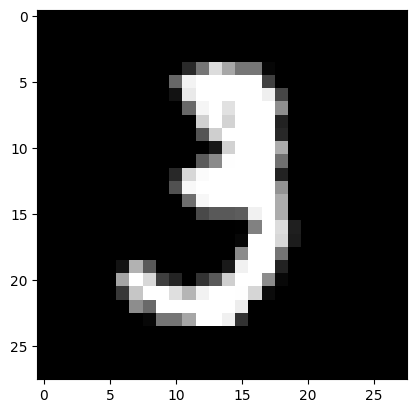

Label: 3


In [ ]:
# Display the image using matplotlib
plt.imshow(image, cmap="gray")  # 'cmap='gray'' shows it in grayscale
plt.show()
print(f"Label: {label}")

# TODO: Try to visualise a different sample from the dataset

## Preparing your data for training using DataLoaders

The `Dataset` we created above retrieves the data one sample at a time. While training a model, we typically want to
1. pass samples in **minibatches**,
2. reshuffle the data at every epoch to **reduce model overfitting** and
3. Use python's `multiprocessing` to **speed up data retrieval**

A dataloader is an _iterable_ that does these things for us.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

We have loaded our dataset into the `Dataloader` and can iterate through the dataset as needed. Each iteration below returns a **batch** of `train_features` and `train_labels`. After we iterate over all batches, the data will **shuffled**.

In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


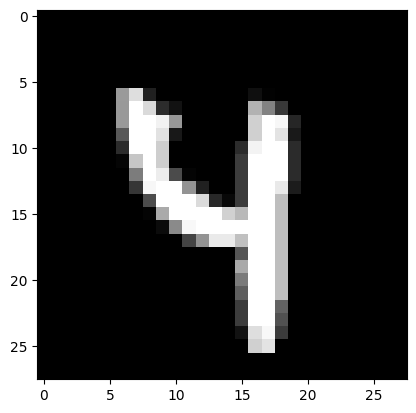

Label: 4


In [ ]:
# Visualising one image from the selected batch

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# TODO: Try to visualise a different sample from this batch

# Build the Neural Network

Neural networks contains layers that perform various operations on data. All the building blocks that you need to build a neural network are available in `torch.nn`.

Every module in PyTorch will be a subclass of `nn.Module`. A neural network is itself a module that consists of other modules (layers). This **nested structure** allows us to build complex architectures easily.

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# check if GPU is availble
print(torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

False
Using cpu device


If you see "Using cpu device" in the second line in the previous cell's output, change your runtime to use a GPU.

In colab,
1. Go to "Runtime" tab
2. Select "Change runtime type"
3. Select "T4 GPU" under "Hardware Accelerator"
4. ⚠️ Wait for the run time to change and run all the previous cells.

Next, we need to define our model by creating a python class. The model class should be a subclass of `nn.Module`.

In the `__init__` method in our class, we can **initialise our neural network**. We need to define the **operations we need to perform on the input data** in the `forward` method.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# Create an object of the model class and move that object to the `device` we
# defined earlier

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


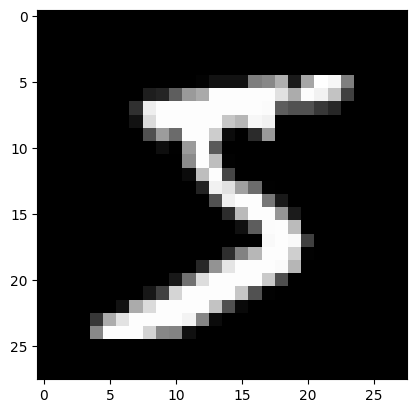

Label: 5

Logits: tensor([[ 0.0182,  0.0267, -0.0011,  0.0528, -0.0236, -0.0067,  0.0334, -0.0234,
          0.0583,  0.0306]], grad_fn=<AddmmBackward0>)

Predicted probabilities: tensor([[0.1001, 0.1010, 0.0982, 0.1037, 0.0960, 0.0977, 0.1017, 0.0961, 0.1042,
         0.1014]], grad_fn=<SoftmaxBackward0>)

Predicted class: tensor([8])


In [ ]:
# To use this model, we pass the input data.
img, label = training_data[0]

# visualising the image
plt.imshow(img.squeeze(), cmap="gray")
plt.show()
print(f"Label: {label}\n")

# Move the image tensor to the specified device (CPU or GPU)
img = img.to(
    device
)  # 'img.to(device)' moves the image to the device (GPU or CPU) to match where the model is located.

# Pass the image through the model to get the raw output (logits)
logits = model(
    img
)  # 'model(img)' performs a forward pass through the model with 'img' as input, returning the raw output (logits).
print(
    f"Logits: {logits}\n"
)  # Print the raw output, which represents unnormalized scores for each class.

# Convert logits to probabilities
predicted_probabilities = nn.Softmax(
    dim=1
)(
    logits
)  # 'Softmax(dim=1)' applies the softmax function to logits to get probabilities. 'dim=1' ensures the function is applied across each class.
print(
    f"Predicted probabilities: {predicted_probabilities}\n"
)  # Print the predicted probabilities for each class, which now sum to 1.

# Determine the predicted class by finding the index with the highest probability
predicted_class = torch.argmax(
    predicted_probabilities, dim=1
)  # 'argmax' finds the class index with the highest probability, indicating the model's prediction.
print(f"Predicted class: {predicted_class}")  # Print the predicted class index.

# TODO: Try with another image

## What happens to the input at each layer in the network?

Let us create a sample minibatch of 3 random images, each of size 28 x 28 and pass it through each layer in the neural network.

```
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
```

In [ ]:
# Create a minibatch containing 3 random images of size 28 x 28
input_minibatch = torch.rand(3, 28, 28)
print(input_minibatch.size())

torch.Size([3, 28, 28])


### nn.Flatten

Let us initialise a `nn.Flatten` module. It converts each 28 x 28 image into a contiguous array of 784 pixels each.

In [ ]:
flatten = nn.Flatten()  # initialise the flatten module
flat_image = flatten(
    input_minibatch
)  # pass the input minibatch through the initialised module
print(flat_image.size())

torch.Size([3, 784])


### nn.Linear

The linear module applies a linear transformation to the input using its stored weights and biases.

In [ ]:
layer1 = nn.Linear(in_features=28 * 28, out_features=512)  # initialise the linear layer
hidden1 = layer1(
    flat_image
)  # pass the output from previous flatten layer through the linear layer
print(hidden1.size())

torch.Size([3, 512])


## nn.ReLU

Non-linear activation functions are what creates the complex mappings between the model's inputs and outputs. They are applied after linear transformations to introduce non-linearity.

In this model, we use the `nn.ReLU` between our layers. There are other non-linear activation functions like `nn.Sigmoid` and `nn.Tanh`.

Read more: [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [nn.Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html)

In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
relu = nn.ReLU()
hidden1 = relu(hidden1)
print(f"After ReLU: {hidden1}")

# TODO: Notice what happened to the negative values in the input before they are passed through ReLU

Before ReLU: tensor([[-0.0719, -0.2445, -0.6022,  ...,  0.3872,  1.0010,  0.0453],
        [-0.2120, -0.1619, -0.7970,  ...,  0.0897,  0.6388,  0.1026],
        [-0.2407, -0.4716, -0.4279,  ...,  0.2648,  0.3774, -0.2786]],
       grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.0000,  ..., 0.3872, 1.0010, 0.0453],
        [0.0000, 0.0000, 0.0000,  ..., 0.0897, 0.6388, 0.1026],
        [0.0000, 0.0000, 0.0000,  ..., 0.2648, 0.3774, 0.0000]],
       grad_fn=<ReluBackward0>)


## nn.Sequential

`nn.Sequential` is an **ordered** container of modules. The data is passed through all the modules in the same order as they are defined.

You can use sequential containers to put together a **block** containing many layers.

In [ ]:
block1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, 10),
)

input_image = torch.rand(3, 28, 28)
print(f"Input mini batch: {input_image.size()}")
logits = block1(input_image)
print(f"Logits: {logits.size()}")

Input mini batch: torch.Size([3, 28, 28])
Logits: torch.Size([3, 10])


## nn.Softmax

The last linear layer of the neural network returns logits. Logits are raw values in [-infty, +infty]. These logits are passed into the softmax module.

Softmax scales the logits to [0, 1], representing the **model's predicted probabilities** for each class.

`dim` parameter indicates the axis along which the values should sum to 1.

In [ ]:
softmax = nn.Softmax(dim=1)
pred_probabilities = softmax(logits)
print(f"Logits\n{logits}\n")
print(f"Predicted probabilities\n{pred_probabilities}")

Logits
tensor([[ 0.0392, -0.0208, -0.1409, -0.0785, -0.0511,  0.0301,  0.0485,  0.0512,
         -0.0321,  0.0561],
        [ 0.0423, -0.0090, -0.1551, -0.1121, -0.0761,  0.0696,  0.0715,  0.0168,
         -0.0260,  0.0009],
        [ 0.0373, -0.0219, -0.1215, -0.0368, -0.0728,  0.0113,  0.0498,  0.0391,
         -0.0285, -0.0297]], grad_fn=<AddmmBackward0>)

Predicted probabilities
tensor([[0.1048, 0.0987, 0.0875, 0.0932, 0.0958, 0.1039, 0.1058, 0.1061, 0.0976,
         0.1066],
        [0.1059, 0.1006, 0.0869, 0.0908, 0.0941, 0.1088, 0.1091, 0.1032, 0.0989,
         0.1016],
        [0.1055, 0.0994, 0.0900, 0.0979, 0.0945, 0.1028, 0.1068, 0.1057, 0.0988,
         0.0986]], grad_fn=<SoftmaxBackward0>)


## Mini Challenge

![image](https://github.com/ntu-dl-bootcamp/deep-learning-2025/raw/main/SESSION2/mini-challenge-session-2.png)

1. Implement the neural network shown in the image above using Pytorch.
2. Train this neural network using suitable hyper parameters
3. Compare the performance of this new neural network with the one before.

## Model parameters

Many layers inside a neural network are parameterised. This means that they have associated weights and biases that are optimised during training.

`nn.Module` tracks all the parameters inside a model object. This can be accessed using the model's `parameters()` and `named_parameters()` methods.

In [ ]:
print(f"Model structure: {model}\n\n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)




In [ ]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0226, -0.0274,  0.0055,  ..., -0.0342, -0.0107,  0.0145],
        [-0.0290, -0.0258,  0.0072,  ...,  0.0328,  0.0231,  0.0225]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0256, -0.0135], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0016,  0.0280, -0.0433,  ...,  0.0249, -0.0177,  0.0295],
        [ 0.0430, -0.0235, -0.0181,  ..., -0.0234,  0.0365, -0.0255]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Size: torch.Size([512]) | Values : tensor([-0.0365, -0.0242], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.4.weight | Size: torch.Size([10, 512]) | Values : tensor([[ 0.0158,  0.0212, -0.0124,  ...,  0.0249, -0.0069, -0.0068],
        [-0.0048,  0.0417,  0.0206,  ...,  0.0163,  0.0324,  0.0302]],
       grad_fn=<SliceBackward0>)

# Optimising the model's parameters

We now have a model and the data to train the model. We can train, validate and test our model by optimising the parameters on our data.

Training a model is an iterative process. In each iteration,
1. the model makes a guess about the output
2. calculates the error in the guess (the loss)
3. collects the derivatives of the error with respect to the parameters
4. optimises these paramters using gradient descent.

## Hyperparameters

Hyperparameters are adjustable parameters that lets us control the optimisation process. Hyperparameter values can impact the model training and convergence rates.

We can define these hyperparameters for training our model:
1. **Number of epochs** - number of times to iterate over our training set.
2. **Batch size** - number of input samples propagated through the network before the model parameters are updated.
3. **Learning rate** - how much to update the models parameters at each batch / epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

## Optimisation loop
Using these hyperparamters, we can train and optimise the paramters of our model with an optimisation loop. Each iteration of the optimisation loop is called as an **epoch**.

Each epoch has two parts
1. Iterate over the training loop and update the parameters
2. Iterate over the test / validation loop and check if the model's performance is improving.

Two important concepts used in the training loop are the loss function and the optimizer.

# Loss function

When presented with some training data, our **untrained network** is likely not to give the correct answer.

Loss function measures the **degree of dissimilarity of obtained result to the target value**, and it is the loss function that we want to **minimize** during training.

To calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions
1. [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) for regression tasks
2. [nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (Negative Log Likelihood) for classification
3. [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) combines `nn.LogSoftmax` and `nn.NLLLoss`.

We will use the Cross Entropy Loss, which will normalise the logits and compute the prediction error.

In [ ]:
# initialise the loss function
loss_fn = nn.CrossEntropyLoss()

## Optimiser

Optimization is the process of **adjusting model parameters to reduce model error in each training step**.

Optimization algorithms define how this process is performed (in this example we use Stochastic Gradient Descent).

All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by **registering the model’s parameters** that need to be trained, and passing in the **learning rate hyperparameter**.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:

1. Call optimizer.zero_grad() to **reset the gradients of model parameters**. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.

2. **Backpropagate the prediction loss** with a call to loss.backward(). PyTorch deposits the gradients of the loss w.r.t. each parameter.

3. Once we have our gradients, we call optimizer.step() to **adjust the parameters** by the gradients collected in the backward pass.

## Full training loop

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # set the model to training mode
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute the prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## Full testing loop

In [ ]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalisation and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

We initialize the loss function and optimizer, and pass it to train_loop and test_loop. Feel free to increase the number of epochs to track the model’s improving performance.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300085  [   64/60000]
loss: 2.292223  [ 6464/60000]
loss: 2.294612  [12864/60000]
loss: 2.283162  [19264/60000]
loss: 2.279641  [25664/60000]
loss: 2.282388  [32064/60000]
loss: 2.272002  [38464/60000]
loss: 2.273226  [44864/60000]
loss: 2.253159  [51264/60000]
loss: 2.254613  [57664/60000]
Test Error: 
 Accuracy: 42.3%, Avg loss: 2.251972 

Epoch 2
-------------------------------
loss: 2.245827  [   64/60000]
loss: 2.235991  [ 6464/60000]
loss: 2.247810  [12864/60000]
loss: 2.227066  [19264/60000]
loss: 2.221572  [25664/60000]
loss: 2.218985  [32064/60000]
loss: 2.211084  [38464/60000]
loss: 2.212244  [44864/60000]
loss: 2.221478  [51264/60000]
loss: 2.179286  [57664/60000]
Test Error: 
 Accuracy: 56.8%, Avg loss: 2.185574 

Epoch 3
-------------------------------
loss: 2.170178  [   64/60000]
loss: 2.178241  [ 6464/60000]
loss: 2.150765  [12864/60000]
loss: 2.124737  [19264/60000]
loss: 2.152570  [25664/60000]
loss: 2.144791  [32064/600

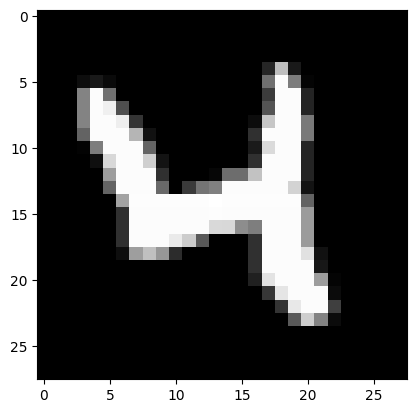

Label: 4

Predicted class: tensor([4])


In [ ]:
img, label = training_data[20]

plt.imshow(img.squeeze(), cmap="gray")
plt.show()
print(f"Label: {label}\n")

img = img.to(device)
logits = model(img)
predicted_probabilities = nn.Softmax(dim=1)(logits)
predicted_class = torch.argmax(predicted_probabilities, dim=1)
print(f"Predicted class: {predicted_class}")

# Save and load the model

PyTorch models store the learned parameters in an internal state dictionary, called state_dict. **These can be saved using the torch.save method.**

In [ ]:
torch.save(model.state_dict(), "model_weights.pth")

To load model weights, you need to create an instance of the same model first, and then load the parameters using `load_state_dict()` method.

In [ ]:
model_new = NeuralNetwork().to(device)

model_new.load_state_dict(torch.load("model_weights.pth"))

<ipython-input-110-3e20348b5a1b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_new.load_state_dict(torch.load('model_weights.pth'))


<All keys matched successfully>

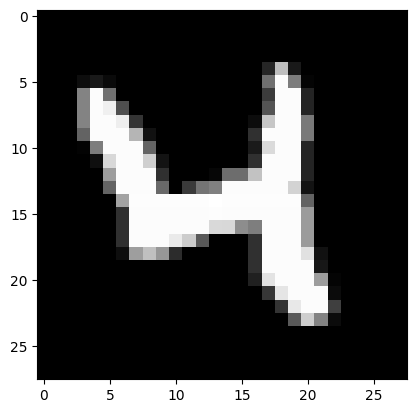

Label: 4

Predicted class: tensor([4])


In [ ]:
# Testing the newly loaded model, `model_new`

img, label = training_data[20]

plt.imshow(img.squeeze(), cmap="gray")
plt.show()
print(f"Label: {label}\n")

img = img.to(device)
logits = model_new(img)
predicted_probabilities = nn.Softmax(dim=1)(logits)
predicted_class = torch.argmax(predicted_probabilities, dim=1)
print(f"Predicted class: {predicted_class}")

# Recommended Reading and Other Resources
1. [What is torch.nn really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html)
2. [PyTorch Beginner Series](https://www.youtube.com/playlist?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN)

This notebook is based on [Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)